# Training Comparison Notebook

## Imports

In [1]:
import numpy as np
import pandas as pd

import logging
from tqdm import tqdm

from covid19_feature import gen_covid19_feat
from poprisk_feature import gen_poprisk_feat
from masks_feature import gen_masks_feat
from popden_feature import gen_popden_feat
from lockdown_feature import gen_lockdown_feat
from bordersclosed_feature import gen_borders_feat
from data import (expand_cases_to_vector,
                  fill_df_column_with_value,
                  fill_df_column_date_based,
                  split_by_date,
                  clean_invalid_data,
                  normalize_data)

import matplotlib.pyplot as plt

import torch as T
import torch.utils.data as tud
from torchsummary import summary
import pytorch_model as ptm

import os
import glob
import argparse

## Some extra stuff

In [2]:
log_format="%(asctime)s - %(message)s"
logging.basicConfig(level=logging.INFO, format=log_format)

# Column order imposed by the data source of the COVID-19
covid_columns = ["Province/State", 
                 "Country/Region", 
                 "Last Update", 
                 "Confirmed", 
                 "Deaths", 
                 "Recovered"]

def arg_val(default, override, kind):
  """Return the argument value to use, making sure it is a list
  """
  if override is None:
    return default
  else:
    return [kind(override)]

def pickle_available(pickle_path):
  """Checks if data used is pickled already

  To-Do: update to check on updates by date from raw data
  """

  if os.path.exists(pickle_path):
    return True


def save_pickle_data(pickle_file, data):
  """Saves the provided data in a pickle file. It assumes pandas dataframe
  as data.
  """

  try:
    data.to_pickle(pickle_file)

  except Exception as e:
    logging.error(f"Wasn't able to save pickled data to {pickle_file}")
    logging.info(e)

def load_pickle_data(pickle_file):
  """Loads and return pickled data. It assumes pandas dataframe
  as data.
  """

  data = None
  try:
    data = pd.read_pickle(pickle_file)
  except Exception as e:
    logging.error(f"Wasn't able to load pickled data from {pickle_file}")
    logging.info(e)
  
  return data

# Generate output folders if they doesn't exist
if not os.path.exists("./models"):
    os.mkdir("./models")

if not os.path.exists("./graphics"):
    os.mkdir("./graphics")

if not os.path.exists("./pickle_cache"):
    os.mkdir("./pickle_cache")

## Set Config

In [3]:
# COVID-19
covid19_repo_url = r"https://github.com/CSSEGISandData/COVID-19/tree/master/" + \
                 r"csse_covid_19_data/csse_covid_19_time_series"
covid_raw_base_url = r"https://raw.githubusercontent.com/CSSEGISandData/" + \
                   r"COVID-19/master/csse_covid_19_data/csse_covid_19_time_series"
covid19_raw_folder = "./data/raw/covid/"
covid19_feat_folder = "./data/features/covid/"

## Get all the data

In [4]:
logging.info(f"Starting...")

# 0. Generate features
pickle_path_bfr = "./pickle_cache/dataset_bfr.pickle"
pickle_path_aft = "./pickle_cache/dataset_aft.pickle"

if not pickle_available(pickle_path_bfr) or not pickle_available(pickle_path_aft):

    logging.info(f"Getting COVID-19 Cases Data...")
    confirmed, deaths, recovered = gen_covid19_feat(covid19_repo_url,
                                                  covid_raw_base_url,
                                                  input_raw=covid19_raw_folder,
                                                  output_folder=covid19_feat_folder,
                                                  avoid_dwld=True)

    # Population Density
    logging.info(f"Getting Population Density Data...")
    popden_raw_file = "./data/raw/popden/popden.csv"
    popden_feat_folder = "./data/features/popden"
    handicaps = {
    "Australia": 3
    }
    popden_df = gen_popden_feat(popden_raw_file,
                              output_folder=popden_feat_folder,
                              handicaps=handicaps,
                              remove_over=True)

    # Masks Usage
    logging.info(f"Getting Masks Usage Data...")
    masks_raw_file = "./data/raw/masks/masks.csv"
    masks_feat_folder = "./data/features/masks"
    masks_df = gen_masks_feat(masks_raw_file,
                            output_folder=masks_feat_folder)

    # Population Risk
    logging.info(f"Getting Population Risk Data...")
    poprisk_raw_file = "./data/raw/poprisk/poprisk.csv"
    poprisk_feat_folder = "./data/features/poprisk"
    poprisk_df = gen_poprisk_feat(poprisk_raw_file,
                                output_folder=poprisk_feat_folder)

    # Gov. Measures 1 - Lockdown
    logging.info(f"Getting Lockdown Data...")
    lockdown_raw_file = "./data/raw/govme/lockdown.csv"
    lockdown_feat_folder = "./data/features/govme"
    lockdown_df = gen_lockdown_feat(lockdown_raw_file,
                                  output_folder=lockdown_feat_folder)

    # Gov. Measures 2 - Borders Closed
    logging.info(f"Getting Borders Closing Data...")
    borcls_raw_file = "./data/raw/govme/borders.csv"
    borcls_feat_folder = "./data/features/govme"
    borders_df = gen_borders_feat(borcls_raw_file,
                                output_folder=borcls_feat_folder)

2020-04-19 18:08:26,923 - Starting...


## Preprocess Data

In [5]:
if not pickle_available(pickle_path_bfr) or not pickle_available(pickle_path_aft):

    # 1. Prepare the data
    # Generate an unique dataset with features | output
    # f1, f2, f3, f4, f5, f6, output
    logging.info(f"Data merge...")
    pbar = tqdm(total=9)

    pbar.set_description("Expand cases into vector of samples...")
    data = expand_cases_to_vector(confirmed)
    pbar.update(1)

    # We feed 0 as default population density since it's the lowest and it's not
    # going to be used for training if it doesn't existc
    pbar.set_description("Fill with Popden feature...")
    fill_df_column_with_value(data, "Popden", popden_df, "Classification", 1)
    pbar.update(1)

    # 0 Default = No Masks
    pbar.set_description("Fill with Masks feature...")
    fill_df_column_with_value(data, "Masks", masks_df, "Mask", 0)
    pbar.update(1)

    # 1 Default = Lowest Risk
    pbar.set_description("Fill with Poprisk feature...")
    fill_df_column_with_value(data, "Poprisk", poprisk_df, "Classification", 1)
    pbar.update(1)

    # 0 Default = Doesn't apply
    pbar.set_description("Fill with Lockdown feature...")
    fill_df_column_date_based(data, "Lockdown", lockdown_df, 0)
    pbar.update(1)
    pbar.set_description("Fill with Borders feature...")
    fill_df_column_date_based(data, "Borders", borders_df, 0)
    pbar.update(1)

    # Split by date
    pbar.set_description("Split data up to March, 16th...")
    limit_date = "03/31/20"
    bfr, aft = split_by_date(data, limit_date)
    pbar.update(1)

    # Clean invalid data
    pbar.set_description("Removing samples with 0 next day cases...")
    bfr = clean_invalid_data(bfr)
    aft = clean_invalid_data(aft)
    pbar.update(1)

    # Normalize
    pbar.set_description("Normalize data before training...")
    bfr = normalize_data(bfr, norm_cases=False)
    aft = normalize_data(aft, norm_cases=False)
    pbar.update(1)

    # Save data for next runs
    pbar.set_description("Saving pickled data...")
    save_pickle_data(pickle_path_bfr, bfr)
    save_pickle_data(pickle_path_aft, aft)
    pbar.update(1)
    pbar.close()

else:

    logging.info(f"Loading pickled data...")
    bfr = load_pickle_data(pickle_path_bfr)
    aft = load_pickle_data(pickle_path_aft)
    
# TEMPORAL FIX
# bfr.loc[:, "NextDay"] = bfr.loc[:, "NextDay"] * 100
# aft.loc[:, "NextDay"] = aft.loc[:, "NextDay"] * 100
bfr.loc[:, "Cases"] = np.log(bfr.loc[:, "Cases"])
bfr.loc[:, "NextDay"] = np.log(bfr.loc[:, "NextDay"])

aft.loc[:, "Cases"] = np.log(aft.loc[:, "Cases"])
aft.loc[:, "NextDay"] = np.log(aft.loc[:, "NextDay"])

2020-04-19 18:08:26,947 - Loading pickled data...


## Split Data, Generate Dataframes

In [6]:
# 2. Split in training data, test and prediction data
device = 'cuda' if T.cuda.is_available() else 'cpu'

logging.info(f"Data setup to feed the model...")

x_cols = (np.arange(len(bfr.columns)) > 1)
x_cols[-1] = False
y_cols = np.arange(len(bfr.columns)) == (len(bfr.columns) - 1)

dataset = ptm.df_2_dataset(bfr, x_cols, y_cols, device)

# Split dataset into training and validate parts
logging.info("Split dataset into training / validate...")
train_dataset, val_dataset = ptm.split_dataset(dataset, 0.9, 0.1)

2020-04-19 18:08:26,980 - Data setup to feed the model...
2020-04-19 18:08:26,986 - Split dataset into training / validate...


## Prepare dataframe for cases and data from evaluation

In [7]:
logging.info(f"Creating dataframe to store all models...")
results = pd.DataFrame(
columns = [
  "Model",
  "Config",
  "Epochs",
  "Batch",
  "Lr",
  "Hidden",
  "Iter",
  "ValLoss"
]
)

logging.info(f"Setting up folders where to extract data...")
training_folders = [
    #"./../results_mse"
    # "./../results_normal",
    "./../results_log_final"
]

2020-04-19 18:08:27,008 - Creating dataframe to store all models...
2020-04-19 18:08:27,013 - Setting up folders where to extract data...


## Get all trainings folders and their data

In [8]:
logging.info(f"Looking for all model folders...")
model_folders = []

for folder in training_folders:
    folders = [folder + "/" + item for item in os.listdir(folder)]
    model_folders += folders
    # print(model_folders)

from classes.csv_handler import read_csv_as_df, df_to_csv

logging.info(f"Loading training data from each folder...")
for folder in model_folders:
    
    csv_df = read_csv_as_df(folder + "/index.csv")
    # Remove the index column for later merge
    csv_df.drop(csv_df.columns[0],axis=1,inplace=True)
    #print(csv_df)
    
    # Feed the data from these trainings into the bigger results dataframe
    # tagged with the model of this experiment
    config = folder.split("/")[2].split("_")[1]
    # Model needs a manual map
    model = folder.split("/")[3]
    model = "X/2" if "1" in model else "X*2+1" if "2" in model else "X*2+1 | X"
    
    # Add tags before adding
    csv_df.loc[:, "Model"] = model
    csv_df.loc[:, "Config"] = config
    
    # Add the data to the dataframe
    results = results.append(csv_df, ignore_index=True)
    
print(results)

2020-04-19 18:08:27,027 - Looking for all model folders...
2020-04-19 18:08:27,028 - Loading training data from each folder...


          Model Config  Epochs  Batch        Lr  Hidden  Iter    ValLoss
0           X/2    log    50.0    8.0  0.000100     3.0   0.0   6.141018
1           X/2    log    50.0    8.0  0.000100     3.0   1.0   6.145907
2           X/2    log    50.0    8.0  0.000100     3.0   2.0   0.079893
3           X/2    log    50.0    8.0  0.000100     4.0   0.0   0.357048
4           X/2    log    50.0    8.0  0.000100     4.0   1.0   0.076528
...         ...    ...     ...    ...       ...     ...   ...        ...
3559  X*2+1 | X    log   200.0   48.0  0.000001    20.0   1.0  18.892162
3560  X*2+1 | X    log   200.0   48.0  0.000001    20.0   2.0  23.831977
3561  X*2+1 | X    log   200.0   48.0  0.000001    25.0   0.0  28.341426
3562  X*2+1 | X    log   200.0   48.0  0.000001    25.0   1.0  20.369452
3563  X*2+1 | X    log   200.0   48.0  0.000001    25.0   2.0  23.254449

[3564 rows x 8 columns]


## Plot using minimum value from each training

First we will define the plotting function

In [9]:
def plot_training(df, model, config, lr, color_col, marker_col, x_col, figsize=(18, 12)):
    """ For a fixed Model, Config and Learning Rate, select a column for markers and another
    for colors. Then, select your desired column for the X axis.
    
    Take into account that colors and markers defined need to be enough for your
    unique values in each chosen column.
    """
    
    model_data = df.loc[ df["Model"] == selected_model ]
    exp_data = model_data.loc[ model_data["Config"] == config ]

    # X axis: hidden size
    # Y axis: mean value for ValLoss
    # Different lines (legend): Epoch
    # exp = experiment
    exp = exp_data.loc[:, exp_data.columns[2:]]
    exp = exp.groupby(["Epochs", "Batch", "Lr", "Hidden"]).min()
    exp = exp.reset_index()

    # Removing Iter Column after doing groupby
    plotting_df = exp.drop(["Iter"], axis=1)
    
    data_2_plot = plotting_df.loc[plotting_df["Lr"] == lr, : ]

    # Prepare x axis
    # x_axis = plotting_df.loc[:, "Hidden"].unique().tolist()
    x_axis = plotting_df.loc[:, x_col].unique().tolist()

    # Same amount of color values than the values in the selected column
    color_values = ['b', 'r', 'g', 'k', "y", "m", "c"]
    color_group = color_col # "Epochs"
    cgroup_values = plotting_df.loc[:, color_group].unique().tolist()

    # Same amount of markers values than the values in the selected column
    marker_values = ['x', 'o', '^', "*", "s", "P", "D"]
    marker_group = marker_col # "Batch"
    mgroup_values = plotting_df.loc[:, marker_group].unique().tolist()

    # Plot the lines based on the configuration above
    fig = plt.figure(figsize=figsize)

    for c in range(0, len(cgroup_values)):
        current_color = color_values[c]
        for m in range(0, len(mgroup_values)):
            current_marker = marker_values[m]

            # Prepare legend string
            cm_legend = str(cgroup_values[c]) + " " + color_group + " - " \
                        + str(mgroup_values[m]) + " " + marker_group

            # Retrieve data to plot
            line_plot = data_2_plot.loc[data_2_plot[color_group] == cgroup_values[c], :]
            line_plot = line_plot.loc[line_plot[marker_group] == mgroup_values[m], :]
            line_plot = line_plot.loc[:, "ValLoss"].values.tolist()

            # Actual plot
            plt_line = plt.plot(x_axis, line_plot, c=current_color, marker=current_marker, label=cm_legend)

    plt.legend()
    plt.title(f"Model {selected_model} Config {config} and Lr {lr}")
    plt.xlabel(x_col)
    plt.ylabel("Minimum Validation Loss")
    plt.grid()
    plt.show()

### Plot specific graph: Lr 1e-5, Model X/2, Data Multiples of 5

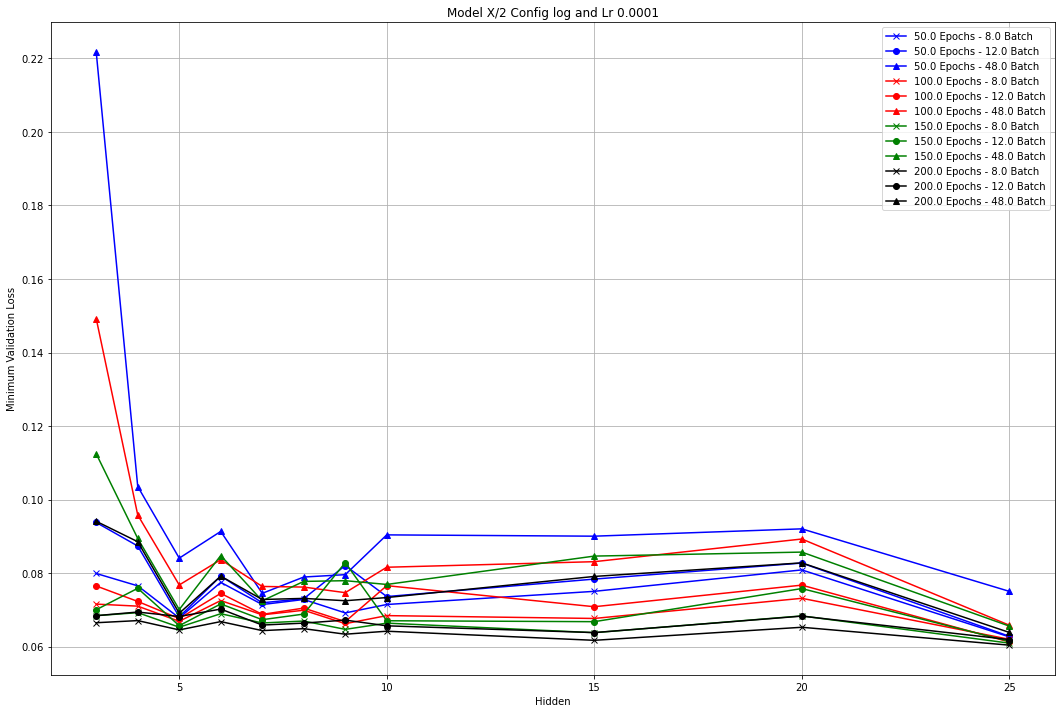

In [10]:
import matplotlib.pyplot as plt

# Plot 01 - Model X/2 and DataPreprocess mul_5
# Plot 01 - Minimum value from trainings

selected_model = "X/2"
config = "log"
lr = 0.0001

color_col = "Epochs"
marker_col = "Batch"
x_col = "Hidden"

plot_training(results, selected_model, config, lr, color_col, marker_col, x_col)


### Plot specific graph: Lr 1e-5, Model X*2+1, Data No Multiples of 5(Continuous)

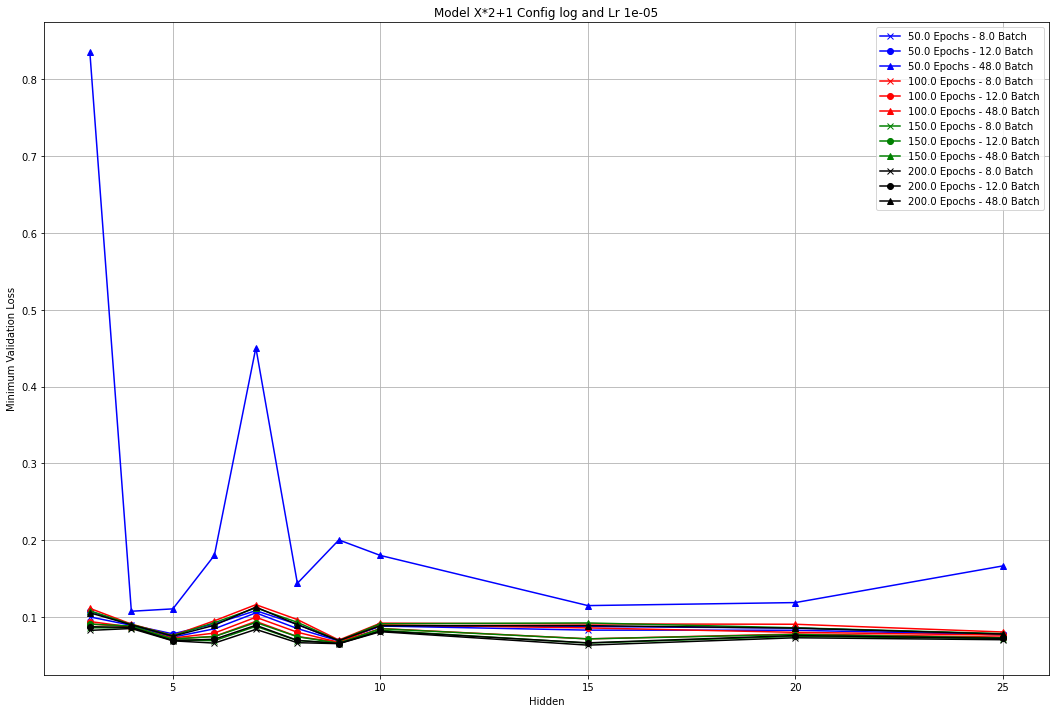

In [11]:
selected_model = "X*2+1"
config = "log"
lr = 0.00001

color_col = "Epochs"
marker_col = "Batch"
x_col = "Hidden"

plot_training(results, selected_model, config, lr, color_col, marker_col, x_col)

### Plot specific graph: Lr 1e-5, Model X*2+1 | X, Data No Multiples of 5(Continuous)

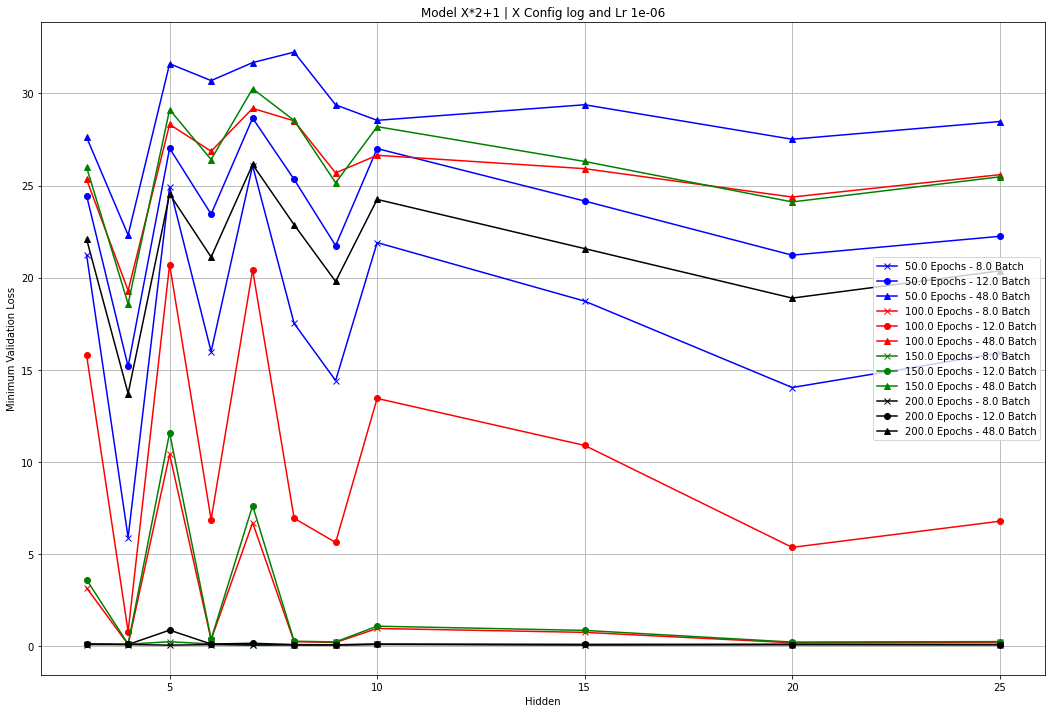

In [12]:
selected_model = "X*2+1 | X"
config = "log"
lr = 0.000001

color_col = "Epochs"
marker_col = "Batch"
x_col = "Hidden"

plot_training(results, selected_model, config, lr, color_col, marker_col, x_col)

## Select the best model based on Validation Loss

We are going to take the model with the best validation loss for each architecture.

Model 1) Input -> X neurons -> X/2 neurons -> Output
Model 2) Input -> X neurons -> X*2+1 -> Output
Model 3) Input -> X neurons -> X*2+1 neurons -> X neurons -> Output

First we will list the top 5 models with less val loss, then select the one preferred manually.

In [32]:
models = results.loc[:, "Model"].unique().tolist()
best_models = {}

for model in models:
    
    top5 = results.loc[ results["Model"] == model ]
    top5 = top5.sort_values(by='ValLoss', ascending=True).head(5)

    best_models[model] = top5.head(1)
    print(top5.head(1))

    Model Config  Epochs  Batch      Lr  Hidden  Iter   ValLoss
921   X/2    log   200.0    8.0  0.0001    25.0   0.0  0.060397
      Model Config  Epochs  Batch      Lr  Hidden  Iter   ValLoss
2178  X*2+1    log   200.0   12.0  0.0001     3.0   0.0  0.050951
          Model Config  Epochs  Batch      Lr  Hidden  Iter   ValLoss
2403  X*2+1 | X    log    50.0    8.0  0.0001    20.0   0.0  0.042945


### Best models

1. X/2          nomul   200.0    8.0  0.001    10.0   2.0  0.006870
2. X*2+1          nomul   200.0    8.0  0.001    10.0   2.0  0.007530
3. X*2+1 | X            mul   150.0   48.0  0.001     9.0   2.0  0.012012

Now we construct the path and file names for each one. We have selected the first one in each case so we can take it from there.

In [43]:
models_files = {}

for k in best_models:
    
    file_name = "..\\"
    folder = "results_" + best_models[k].loc[:, "Config"].values.tolist()[0] + "_final"
    file_name += folder + "\\"
    folder = "models_" + str(models.index(k)+1)
    file_name += folder + "\\"
    file = "model_epochs_" + str(int(best_models[k].loc[:, "Epochs"].values.squeeze())) + "_batch_" \
            + str(int(best_models[k].loc[:, "Batch"].values.squeeze())) + "_lr_" \
            + str(best_models[k].loc[:, "Lr"].values.squeeze()) + "_hidden_" \
            + str(int(best_models[k].loc[:, "Hidden"].values.squeeze())) + "_i_" \
            + str(int(best_models[k].loc[:, "Iter"].values.squeeze())) + "_valloss_" \
            + str(best_models[k].loc[:, "ValLoss"].values.squeeze())
    file_name += file
    models_files[k] = file_name
    
    # The last number can change due to numeric vars
    found_files = glob.glob(models_files[k][:-5] + "*")
    if found_files:
        models_files[k] = found_files
        print(found_files)
        
# If you want to manually set the models
#models_files["X/2"] = ["..\\results_log_final\\models_1\\model_epochs_150_batch_48_lr_1e-05_hidden_25_i_2_valloss_0.1114221311041287"]
# models_files["X*2+1"] = ["..\\results_log_final\\models_2\\model_epochs_150_batch_48_lr_1e-05_hidden_25_i_2_valloss_0.1114221311041287"]
#models_files["X*2+1 | X"] = ["..\\results_log_final\\models_3\\model_epochs_50_batch_12_lr_1e-05_hidden_5_i_1_valloss_0.049420499874811084"]

['..\\results_log_final\\models_1\\model_epochs_200_batch_8_lr_0.0001_hidden_25_i_0_valloss_0.06039683411193148']
['..\\results_log_final\\models_2\\model_epochs_200_batch_12_lr_0.0001_hidden_3_i_0_valloss_0.05095066449471882']
['..\\results_log_final\\models_3\\model_epochs_50_batch_8_lr_0.0001_hidden_20_i_0_valloss_0.04294525007376584']


## Load models to infer

In [44]:
torch_models = {}

for k in models_files:
    
    print(models_files[k])
    model = None
    
    # Construct the model based on its type and paramters
    # Should only have 1 file matching the pattern in the list
    hidden = models_files[k][0].split("\\")[-1].split("_")[8]
    model = ptm.define_model(input_size=int(6),
                             hidden_size=int(hidden),
                             model=k).to(device)
    
    # Debug data
    #name = models_files[k][0].split("\\")[-1]
    #print(f"Model {k} - File {name}")
    #summary(model, input_size=(0, 1, 6))
    
    # Load weights to the model
    model.load_state_dict(T.load(models_files[k][0]))
    
    # Save to dict
    torch_models[k] = model

['..\\results_log_final\\models_1\\model_epochs_200_batch_8_lr_0.0001_hidden_25_i_0_valloss_0.06039683411193148']
['..\\results_log_final\\models_2\\model_epochs_200_batch_12_lr_0.0001_hidden_3_i_0_valloss_0.05095066449471882']
['..\\results_log_final\\models_3\\model_epochs_50_batch_8_lr_0.0001_hidden_20_i_0_valloss_0.04294525007376584']


## Function to plot ground truth vs predictions

In [72]:
def draw_comparison(gt_df, gt_col,
                    pred_df, pred_col, 
                    title="Comparison",
                    output_png="./results/test.png",
                    plot=False,
                    figsize=(6.4, 4.8)):
  """Draws to compare the actual data vs the predicted data.
  """

  g_truth = gt_df[gt_col].to_numpy(dtype=float)
  predict = pred_df[pred_col].to_numpy(dtype=float)

  x = []
  import datetime as dt
  for i in np.arange(0, len(g_truth)):
    day = dt.datetime.strptime(f"0{i+1}/04/2020", "%d/%m/%Y")
    x.append(day.strftime('%d/%m/%Y'))
    
  # Draw it

  plt.rcParams['legend.numpoints'] = 1
  fig, ax = plt.subplots(figsize=figsize, dpi=200)

  for i in range(len(g_truth)):
    ax.plot([i,i],[predict[i], g_truth[i]], c="k", linewidth=0.5)

  ax.scatter(x, g_truth, color="green", marker="o", label="Ground Truth")
  ax.scatter(x, predict, color="red", marker="^", label="Prediction")

  # Put the labels
  # plt.xticks(x, labels, rotation='vertical')

  plt.legend()
  plt.title(title)
  plt.grid()
  
  if os.path.isfile(output_png):
    os.remove(output_png)

  fig.savefig(output_png)

  if plot:
    # plt.ylim(10.98, 11.02)
    plt.show()

## Predict and plot against ground truth

2020-04-19 20:19:03,631 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2020-04-19 20:19:03,635 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2020-04-19 20:19:03,638 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


           Cases    Popden  Masks   Poprisk  Lockdown  Borders        NextDay  \
0  110065.028388  0.333333    0.0  0.333333       0.5      0.5  113958.974312   
1   65201.981102  0.333333    0.0  0.333333       0.5      0.5   90847.957952   
2   57749.008849  0.333333    0.0  0.333333       0.5      0.5   59928.983230   
3   90847.957952  0.333333    0.0  0.333333       0.5      0.5   93772.999364   
4   93772.999364  0.333333    0.0  0.333333       0.5      0.5   98963.016413   
5  113958.974312  0.333333    0.0  0.333333       0.5      0.5  118780.990353   
6   59928.983230  0.333333    0.0  0.333333       0.5      0.5   65201.981102   
7   98963.016413  0.333333    0.0  0.333333       0.5      0.5  110065.028388   

            yhat  
0  112254.492447  
1   67578.689864  
2   60077.936597  
3   93203.641902  
4   96110.717303  
5  116101.711429  
6   62274.814579  
7  101262.139352  


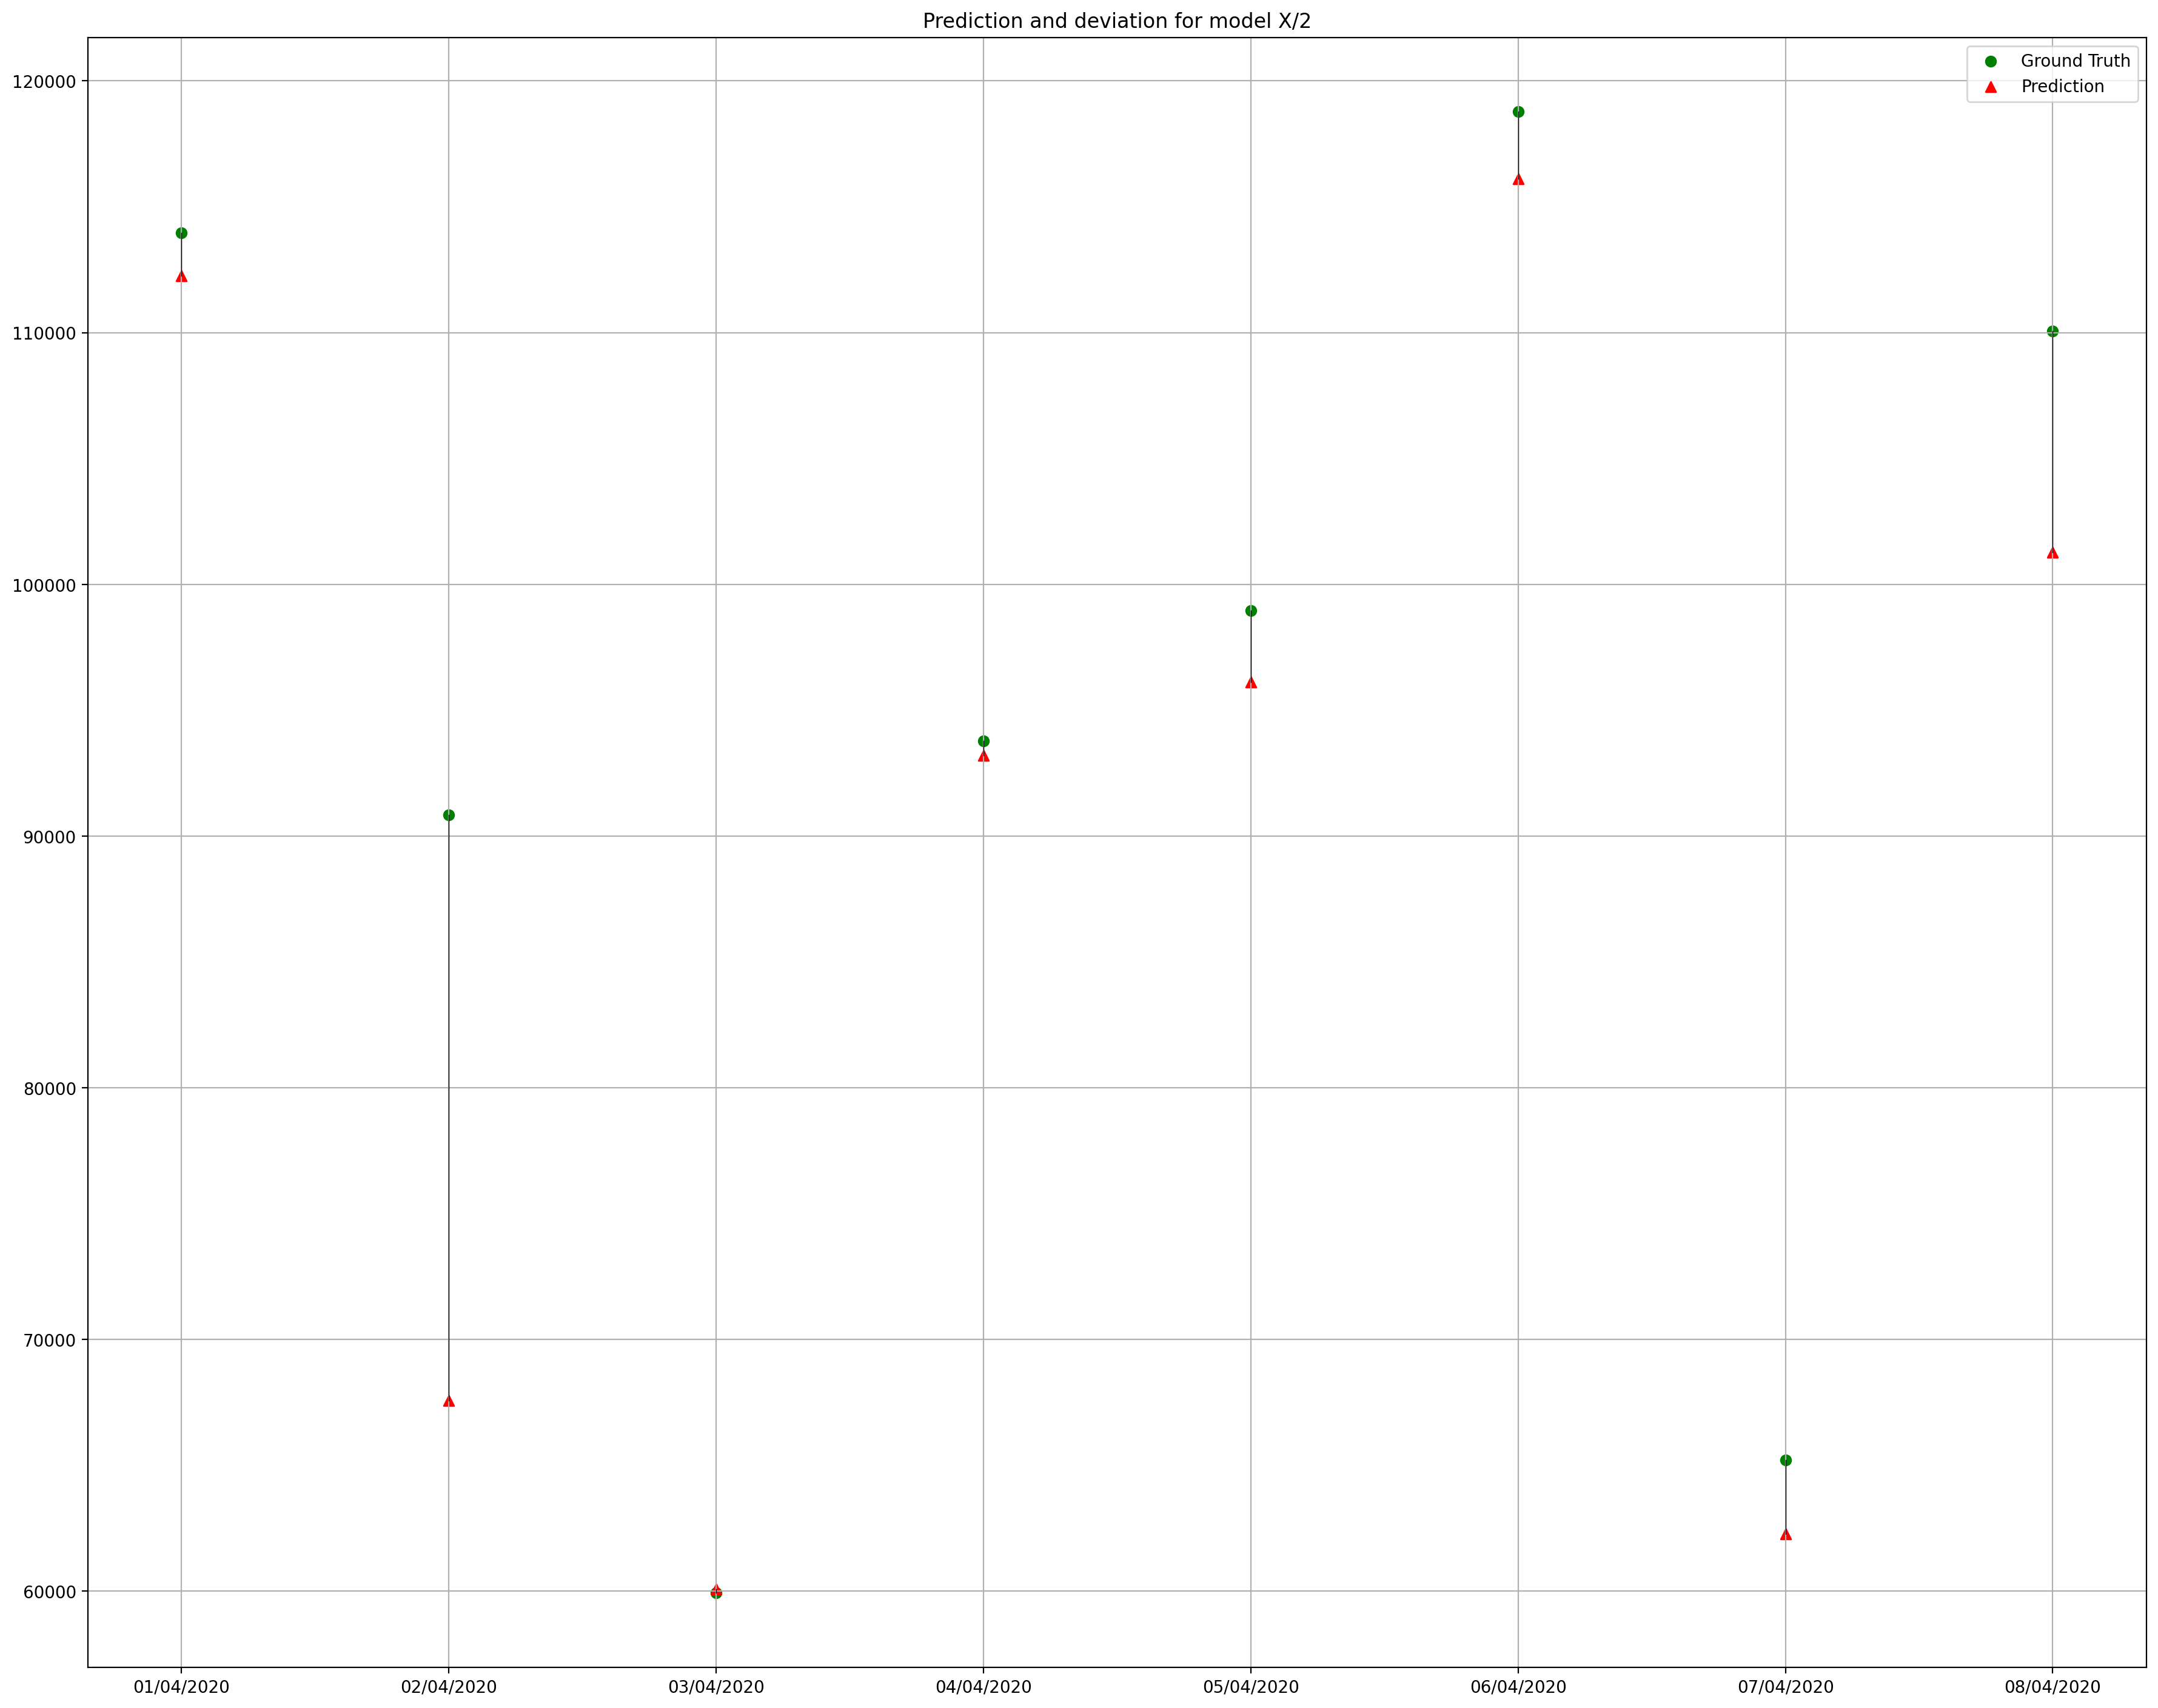

2020-04-19 20:19:05,098 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2020-04-19 20:19:05,101 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2020-04-19 20:19:05,104 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


           Cases    Popden  Masks   Poprisk  Lockdown  Borders        NextDay  \
0   57749.008849  0.333333    0.0  0.333333       0.5      0.5   59928.983230   
1  110065.028388  0.333333    0.0  0.333333       0.5      0.5  113958.974312   
2   65201.981102  0.333333    0.0  0.333333       0.5      0.5   90847.957952   
3   98963.016413  0.333333    0.0  0.333333       0.5      0.5  110065.028388   
4   90847.957952  0.333333    0.0  0.333333       0.5      0.5   93772.999364   
5   59928.983230  0.333333    0.0  0.333333       0.5      0.5   65201.981102   
6   93772.999364  0.333333    0.0  0.333333       0.5      0.5   98963.016413   
7  113958.974312  0.333333    0.0  0.333333       0.5      0.5  118780.990353   

            yhat  
0   61627.526400  
1  115862.795434  
2   69402.249572  
3  104410.904817  
4   96023.223454  
5   63903.674403  
6   99048.276893  
7  119873.570399  


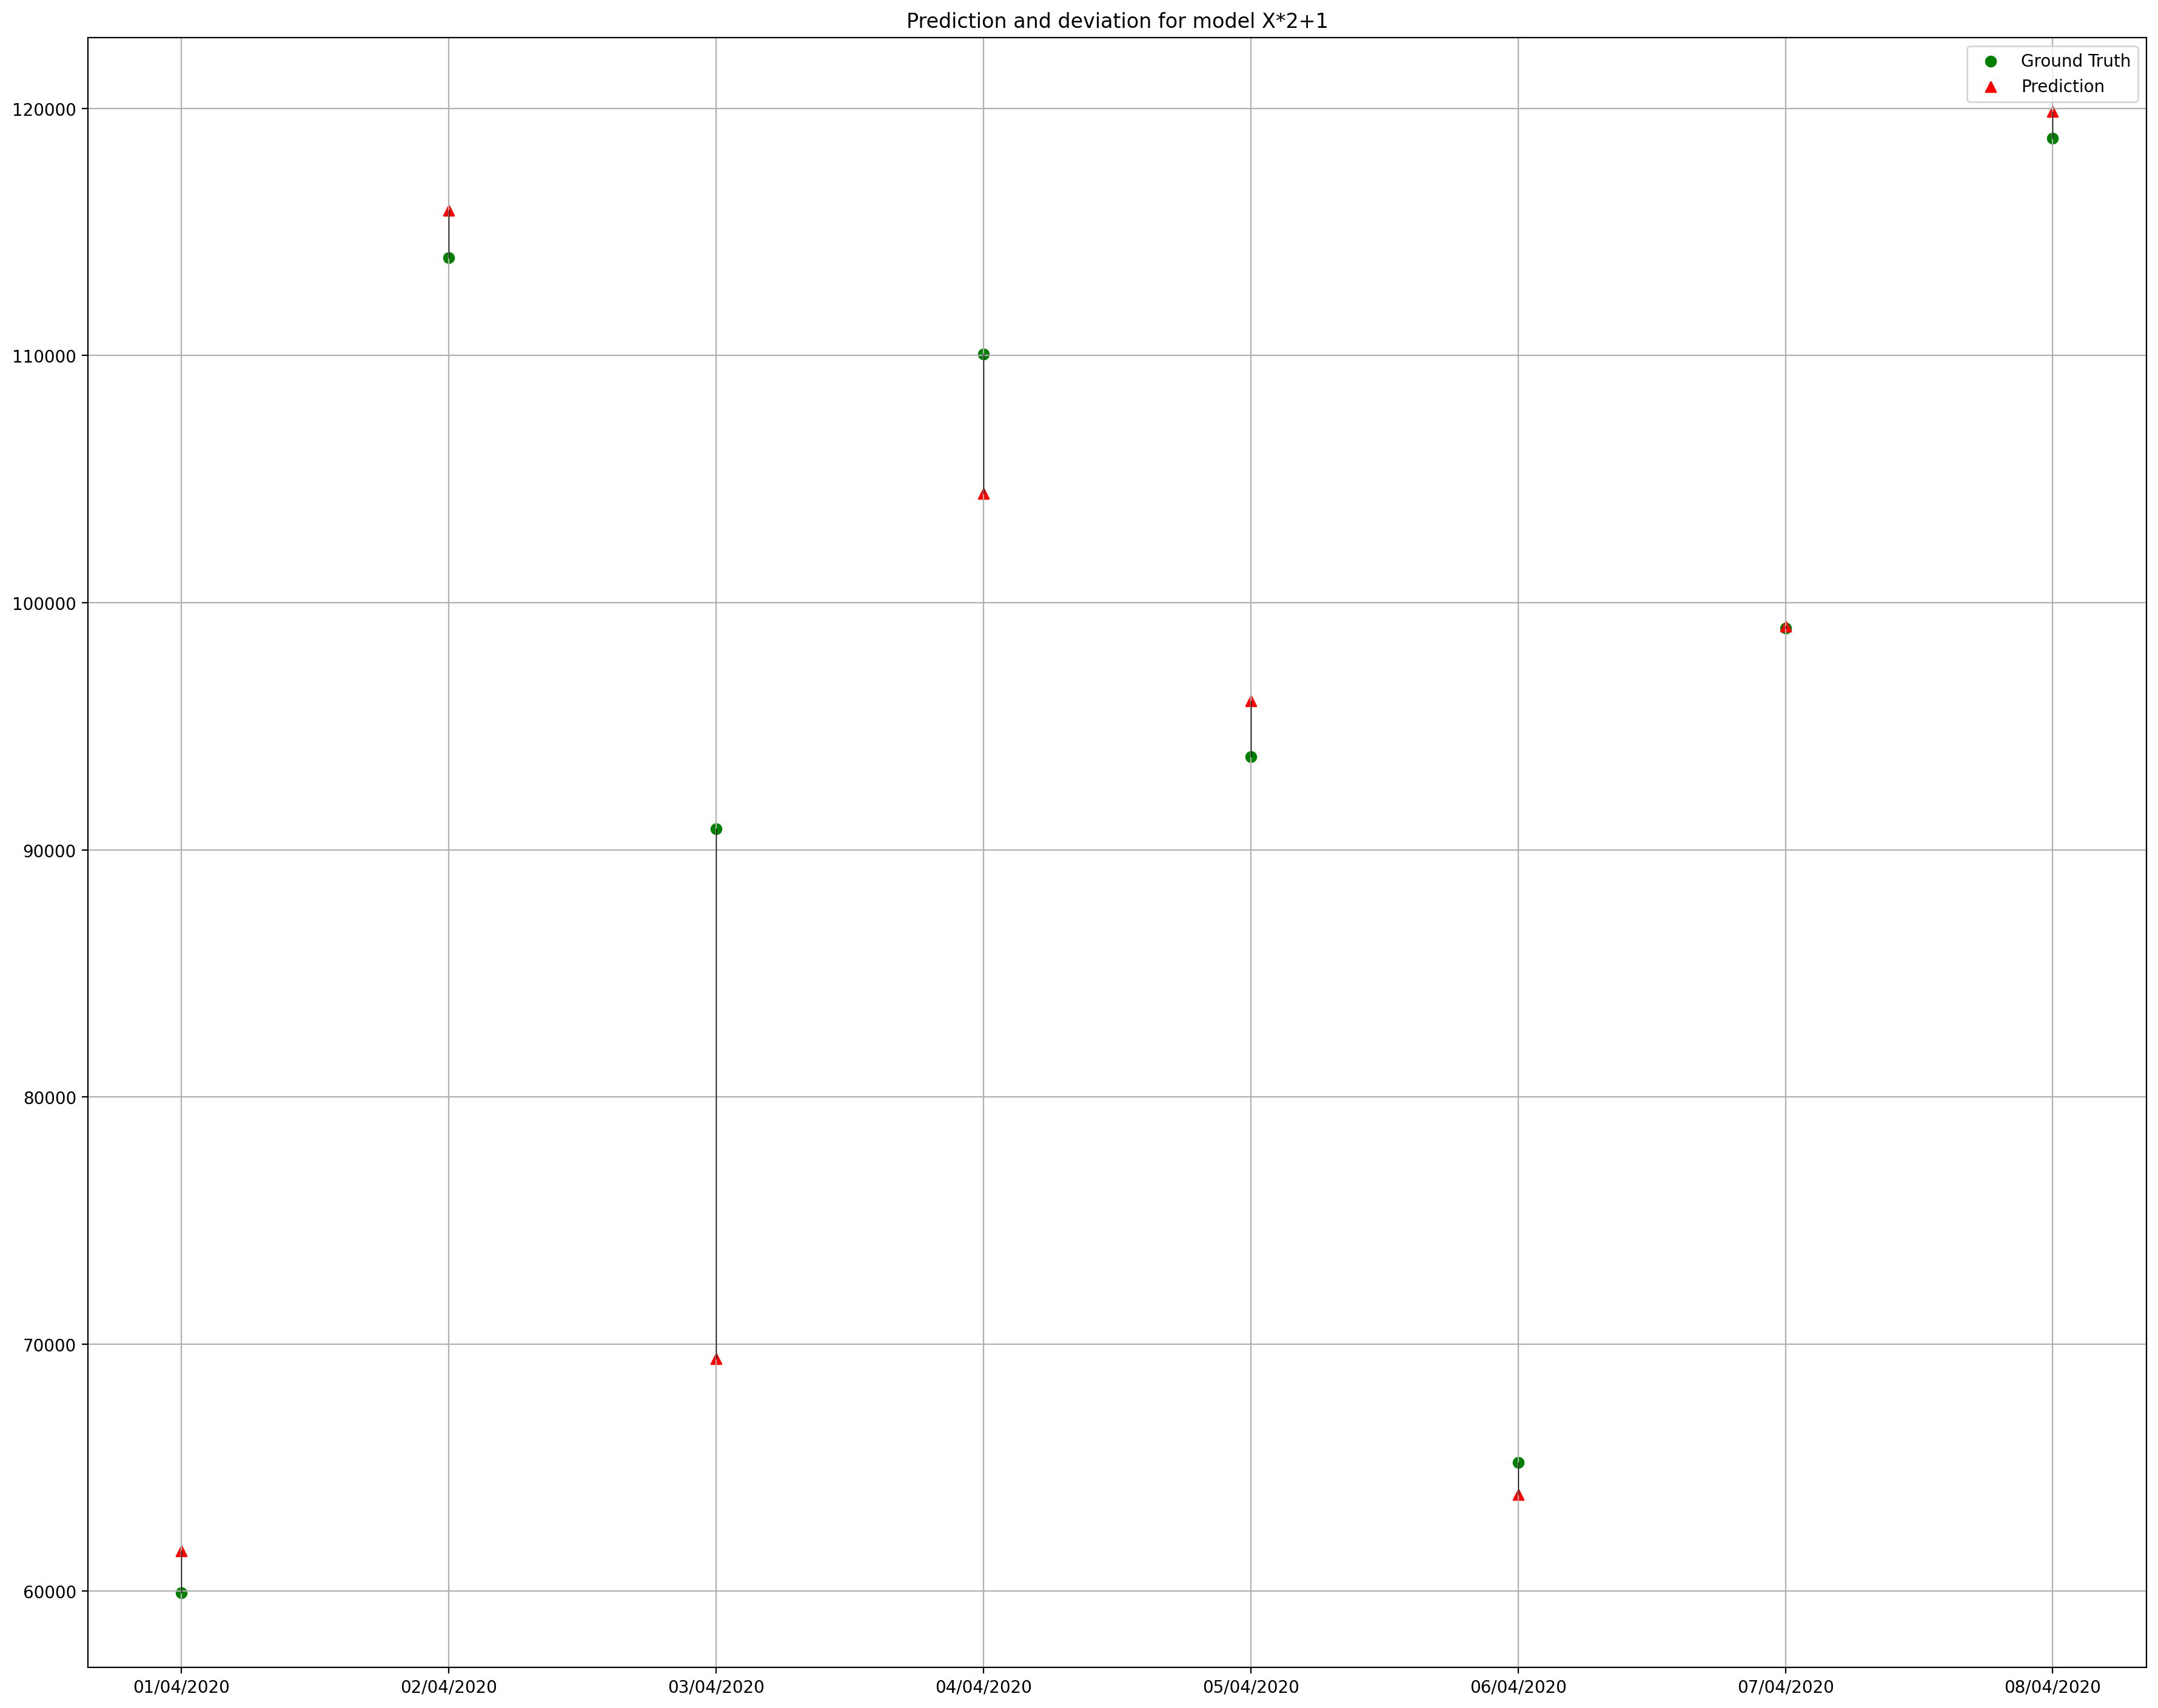

2020-04-19 20:19:06,497 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2020-04-19 20:19:06,501 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2020-04-19 20:19:06,504 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


           Cases    Popden  Masks   Poprisk  Lockdown  Borders        NextDay  \
0   59928.983230  0.333333    0.0  0.333333       0.5      0.5   65201.981102   
1   65201.981102  0.333333    0.0  0.333333       0.5      0.5   90847.957952   
2   98963.016413  0.333333    0.0  0.333333       0.5      0.5  110065.028388   
3   93772.999364  0.333333    0.0  0.333333       0.5      0.5   98963.016413   
4   57749.008849  0.333333    0.0  0.333333       0.5      0.5   59928.983230   
5   90847.957952  0.333333    0.0  0.333333       0.5      0.5   93772.999364   
6  113958.974312  0.333333    0.0  0.333333       0.5      0.5  118780.990353   
7  110065.028388  0.333333    0.0  0.333333       0.5      0.5  113958.974312   

            yhat  
0   61117.737363  
1   66279.184298  
2   98980.761159  
3   93986.530040  
4   58978.886731  
5   91167.003168  
6  113356.530322  
7  109631.115993  


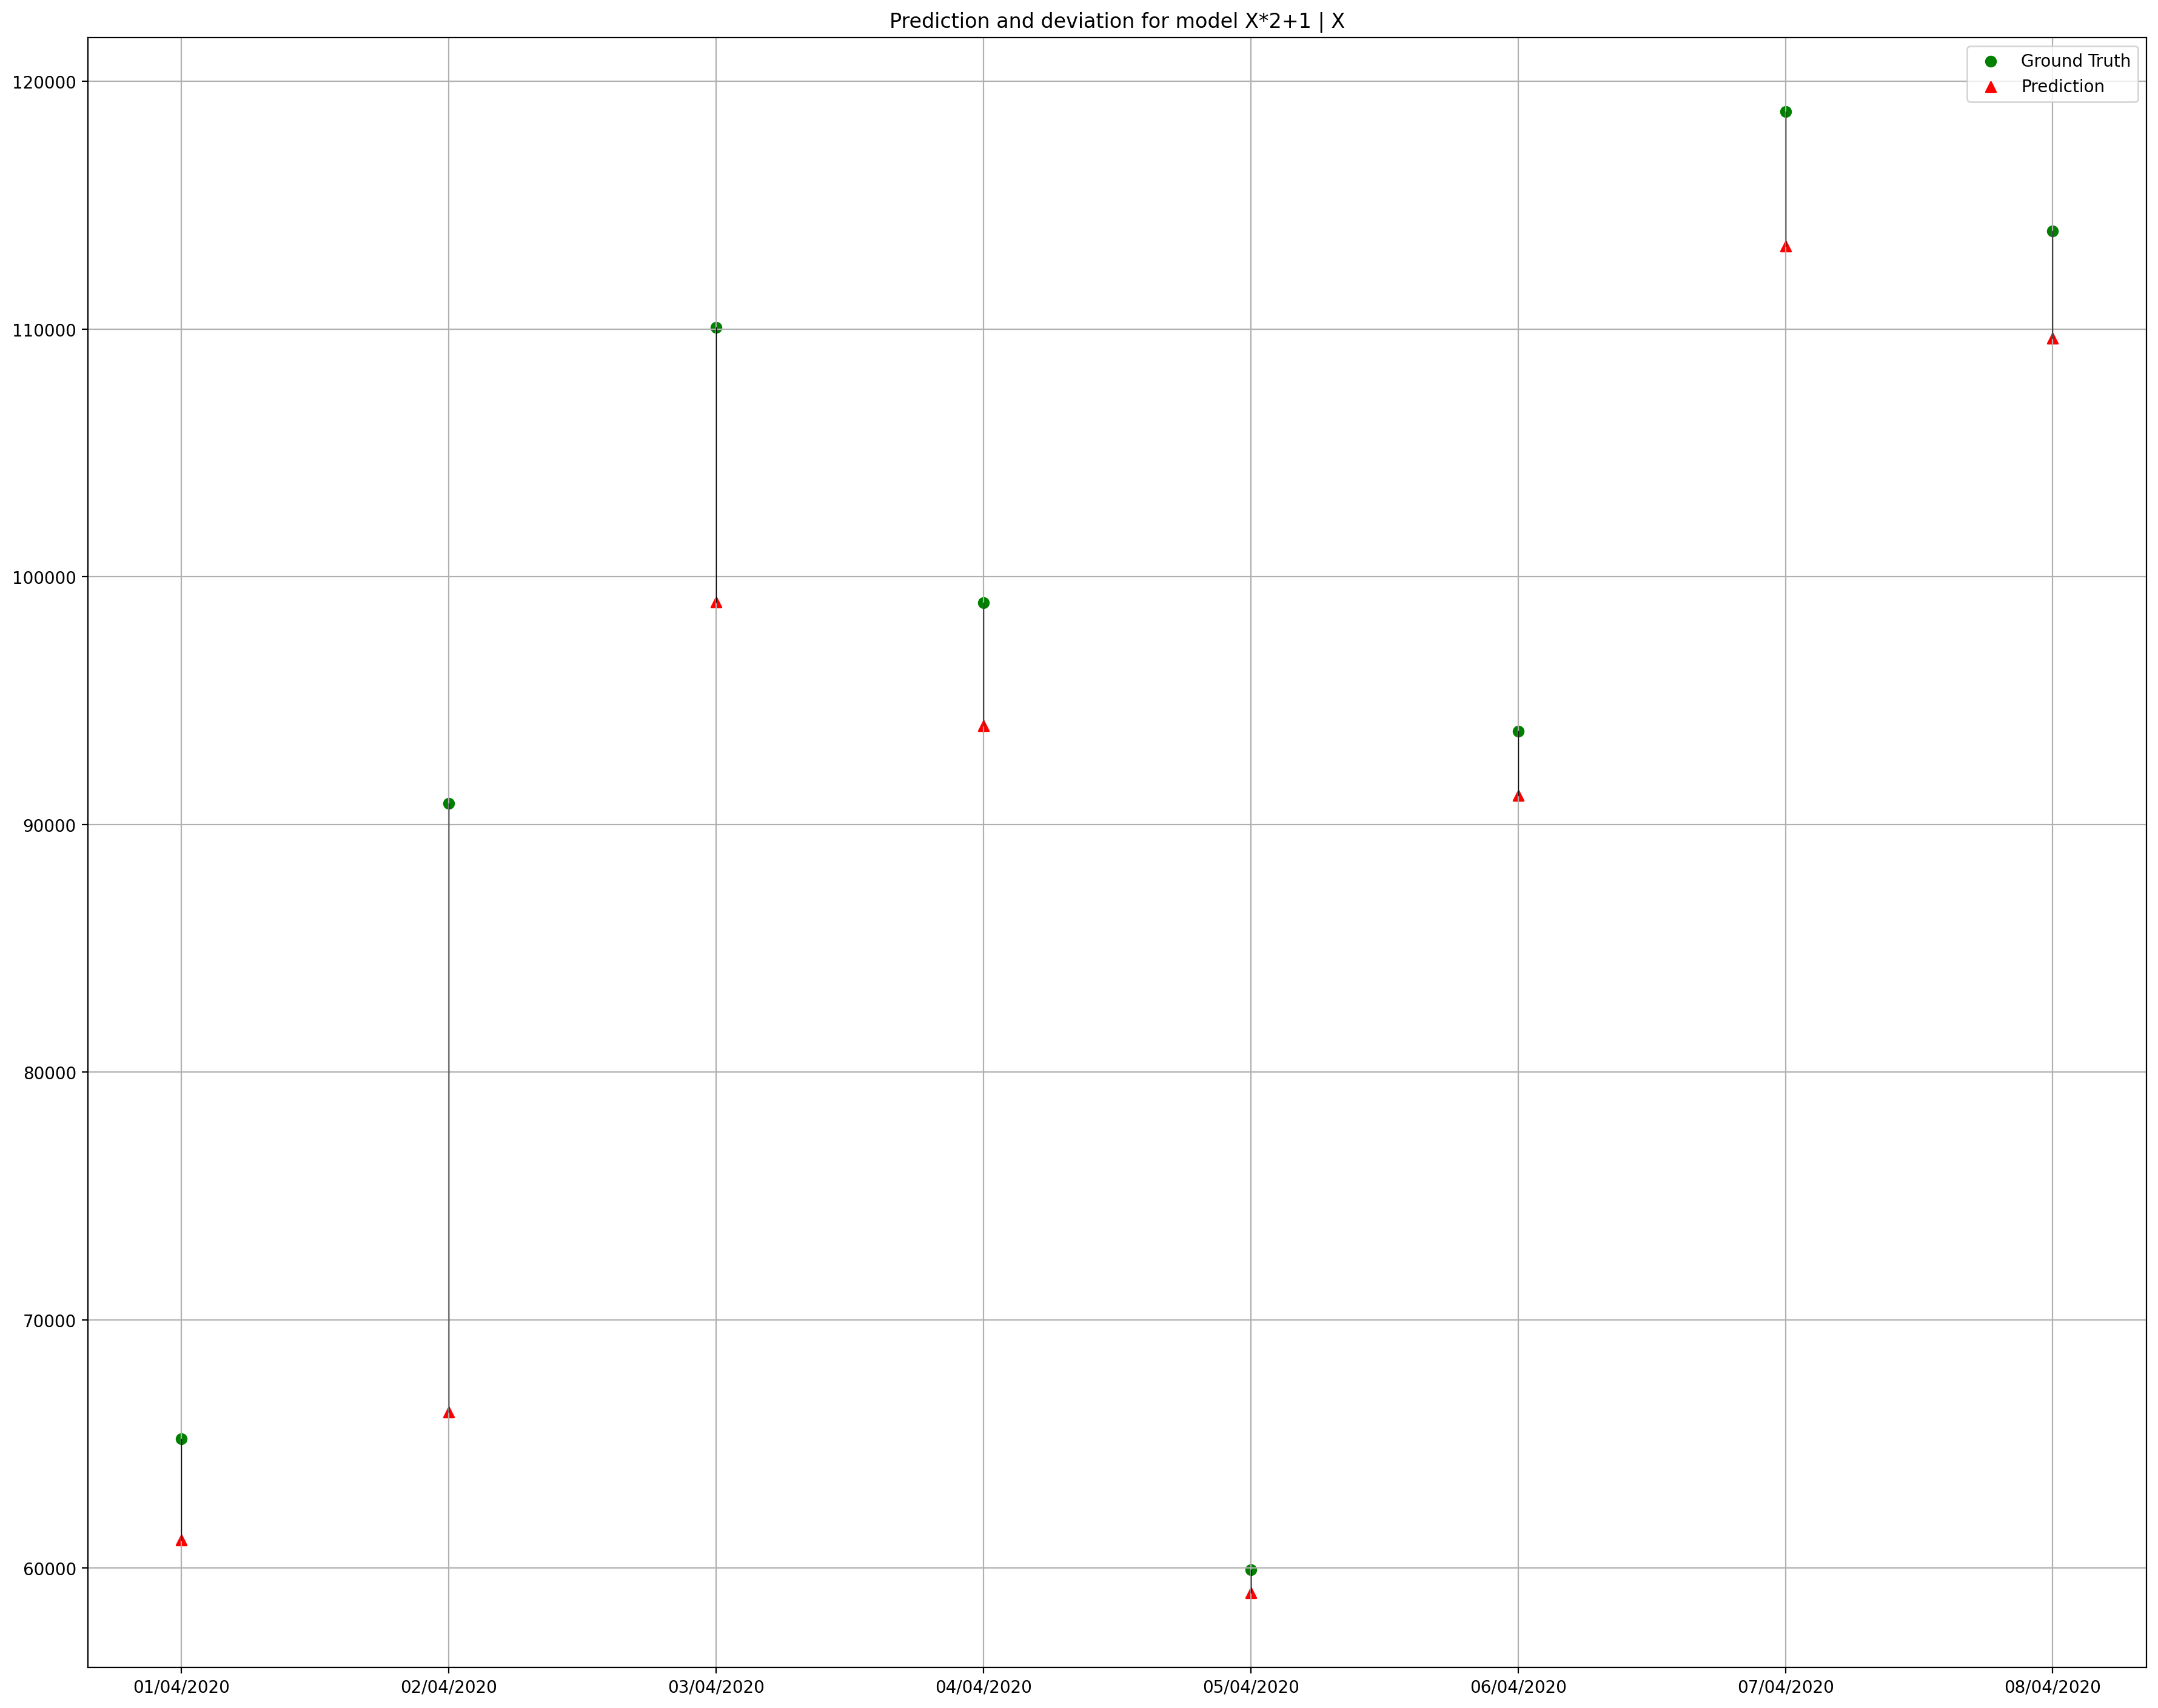

In [75]:
figsize = (21.9, 17.8)

# Inference dataset as datagenerator
spain_dataset = aft.loc[ aft["Country"] == "France", :]
infer_dataset = ptm.df_2_dataset(spain_dataset, x_cols, y_cols, device)
infer_loader = ptm.datagen(dataset=infer_dataset,
                           batch_size=1)

for model in torch_models:
    
    # Predict
    predictions = ptm.predict(torch_models[model], device, data_loader=infer_loader)
    
    predictions_df = pd.DataFrame(predictions, columns=[
      "Cases",
      "Popden",
      "Masks",
      "Poprisk",
      "Lockdown",
      "Borders",
      "NextDay",
      "yhat"
    ])
    
    predictions_df.loc[:, "NextDay"] = np.exp(predictions_df.loc[:, "NextDay"])
    predictions_df.loc[:, "Cases"] = np.exp(predictions_df.loc[:, "Cases"])
    predictions_df.loc[:, "yhat"] = np.exp(predictions_df.loc[:, "yhat"])
    print(predictions_df)
    
    
    # Draw
    model_for_filename = model.replace("/", "_")
    model_for_filename = model_for_filename.replace("*", "x")
    model_for_filename = model_for_filename.replace("|", "__")
    model_for_filename = model_for_filename.strip()
    draw_comparison(predictions_df, 
                    "NextDay",
                    predictions_df,
                    "yhat",
                    title=f"Prediction and deviation for model {model}",
                    plot=True,
                    output_png=f"./results/{model_for_filename}_test.png",
                    figsize=(21.9, 17.8))

## Function to Plot Country Cases vs Prediction

In [18]:
def draw_cases(data_df, cases_col, x_col,
               pred_df, pred_col, 
               title="Comparison",
               output_png="./results/test.png",
               plot=False,
               figsize=(6.4, 4.8)):
  """Draws to compare the actual data vs the predicted data in a continuous way
  """

  fig = plt.figure(figsize=figsize, dpi=288)
    
  g_truth = data_df[cases_col].to_numpy(dtype=float)
  predict = pred_df[pred_col].to_numpy(dtype=float)

  # x = np.arange(0, len(g_truth))
  x = data_df.loc[:, x_col].to_numpy(str)

  plt.plot(x, g_truth, color="green", marker="o", label="Ground Truth")
  plt.plot(x, predict, color="red", marker="^", label="Prediction")

  # Put the labels
  # plt.xticks(x, labels, rotation='vertical')

  plt.legend()
  plt.title(title)
  plt.grid()
  
  if os.path.isfile(output_png):
    os.remove(output_png)

  fig.savefig(output_png)

  if plot:
    # plt.ylim(0, 0.00002)
    plt.show()

In [19]:
def is_in_array(num, array):
  
  for item in array:
    if np.allclose([num], [item]):
      return 1

  return 0

def find_coincidences(df_data, df_pred):

  masks = []
  feats = ["Cases","Popden","Masks","Poprisk","Lockdown", "Borders"]
  for feat in feats:
    df_data = df_data.loc[:, feat].values.tolist()
    df_pred = df_pred.loc[:, feat].values.tolist()
    mask = [ is_in_array(item, df_pred) for item in df_data]
    print(f"Feat {feat}")
    print(mask)
    if sum(mask) == 0:
      vals = df_data.loc[:, feat].values.tolist()
      print(f"{vals}")
    
    if len(masks) > 0:
      pass

  #mask = df['A'].values == 'foo'
  #return df.loc[mask]

In [20]:
country = "Spain"

# Data from the country
data_spain = aft.loc[aft.loc[:, "Country"] == country, :].copy()

# Find elements from the prediction that are from Spain based on their values
find_coincidences(data_spain, predictions_df)

draw_cases(data_spain, 
           "NextDay",
           "Date",
           predictions_df,
           "yhat",
           title=f"Cases history {country}",
           plot=True,
           output_png=f"./results/{country}_history.png",
           figsize=(21.9, 17.8))

Feat Cases
[1, 1, 1, 1, 1, 1, 1, 1]


AttributeError: 'list' object has no attribute 'loc'